# RGI19 (Antarctic and Subantarctic)

F. Maussion & S. Galos

Same as RGI6

In [ ]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist
import os

## Files and storage paths

In [ ]:
# Region of interest
reg = 19

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '19_rgi60_AntarcticSubantarctic.zip')

### Load the input data

In [ ]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [ ]:
sdf, _ = submission_summary(shp)
sdf

In [ ]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [ ]:
rgi7 = shp.loc[shp['subm_id']==585].copy()
rgi7['is_rgi6'] = True

In [ ]:
# Size filter?
needs_size_filter(rgi7)

### Some sanity checks 

In [ ]:
sdf, df_class = submission_summary(rgi7)
df_class

In [ ]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area
        orphan_f = orphan_f.loc[orphan_f.subm_id.isin(rgi7.subm_id.unique()[check])]

In [ ]:
orphan_f['area'].sum() * 1e-6

### Plots 

In [ ]:
plot_map(rgi7, reg, linewidth=3)

In [ ]:
plot_map(rgi7, reg, linewidth=3, is_rgi6=True)

In [ ]:
plot_date_hist(rgi7, reg, figsize=(16, 7))

### Text for github

In [ ]:
fgh = sdf.T
fgh

In [ ]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

## Write out and tar 

In [ ]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

## Consistency check with RGI6 

#### load reference data (here RGI6 original) to enable comparison

In [ ]:
# load reference data
from utils import open_zip_shapefile
ref_odf = open_zip_shapefile(rgi6_reg_file)

#### Number of elements (differences depict problems)

In [ ]:
print('Number of glaciers in new RGI subset:', len(rgi7))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(rgi7)-len(ref_odf))

#### Check for 'nominal glaciers' in the RGI6 original data and delete them from new RGI subset from GLIMS if they are in there 

In [ ]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2]
len(nom)

#### Total area

In [ ]:
# add an area field to RGI_ss and reference data
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [ ]:
# print and compare area values
Area_Rep = rgi7['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
d = (Area_Rep - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

3 km² area difference... which mainly originate from "small" outline differences between RGI06 original and the outlines of RGI06 extracted from the Glims data base. Main sources may be glaciers RGI60-19.00707 and RGI60-19.00168 (and possibly others). This is similar to what happend in Greenland (figure of 8 in the rock outcrops), but much less area is added so its ok.

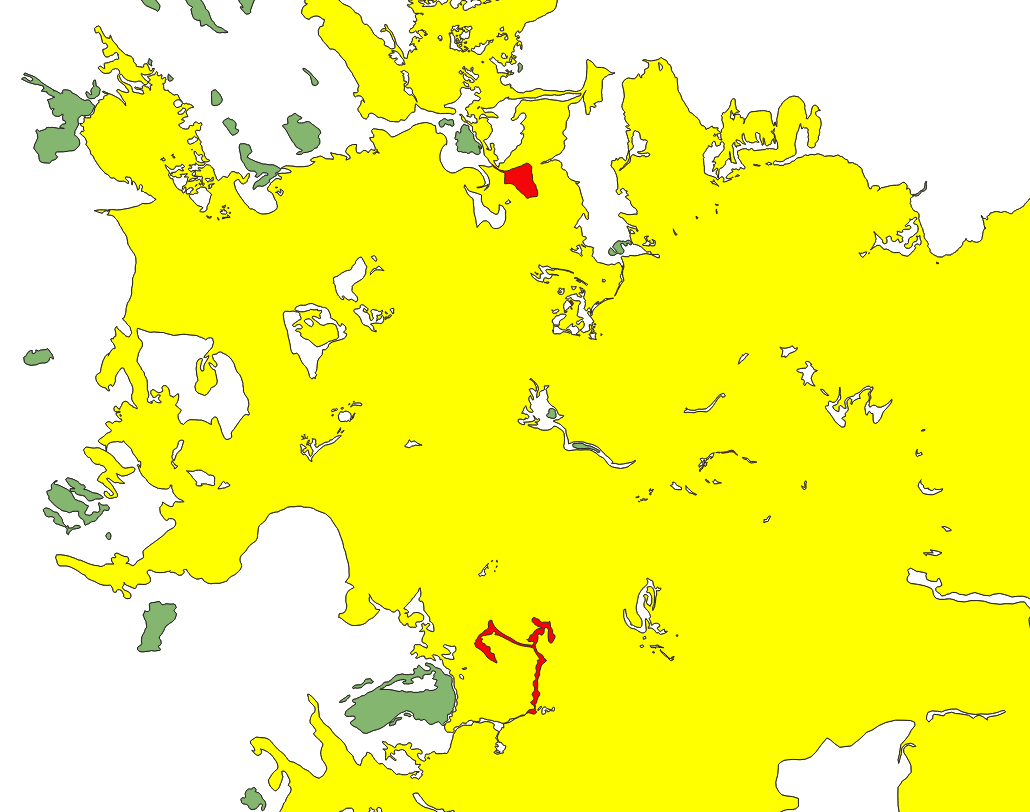